In [15]:
import yfinance as yf
import pandas_datareader.data as pdr
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime
yf.pdr_override()

#For reproducability
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

/var/folders/9m/qcg58ft12w72z4h1j7s196w00000gn/T/ipykernel_20898/4148268436.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Data processing


In [16]:
# Some functions to help out with
def plot_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price')
    plt.legend()
    plt.show()

def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price Return')
    plt.title(f'{symbol} Stock Return Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price Returns')
    plt.legend()
    plt.show()
    
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def get_ticker_data(ticker: str, param_start_date, param_end_date) -> tuple:
    # Fetch data from Yahoo Finance
    data = pdr.get_data_yahoo(ticker, start=param_start_date, end=param_end_date)
    data.reset_index(inplace=True)
    data = data.fillna(method="ffill", axis=0)
    data = data.fillna(method="bfill", axis=0)
    
    # Prepare the data
    prices = data["Close"].values.reshape(-1, 1)
    
    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    prices = scaler.fit_transform(prices)
    
    # Create sequences
    SEQ_LEN = 8 # I assumed the sequence length, you can change this value as per your requirements
    inputs, targets = [], []
    for i in range(SEQ_LEN, len(prices) - 1):
        inputs.append(prices[i - SEQ_LEN:i])
        targets.append(prices[i + 1])

    return data, np.array(inputs), np.array(targets)

def fetch_ticker_data(ticker: str, start_date, end_date) -> tuple:
    return get_ticker_data(ticker, start_date, end_date)
def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e

#Scaled Exponentially-Regularized Linear Unit to try out - if anyone can make this work, let me know.

# def serlu(x, lambdaa=1.07862, alphaa=2.90427):
#     result = tf.cond(x >= 0, lambda: tf.math.multiply(lambdaa, x), lambda: tf.math.multiply(lambdaa, alphaa, x, tf.exp(x)))
#     return result


# Get the Data

In [17]:
# Example usage:

symbol_to_fetch = 'IBM'
start_date = '2020-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
stock, inputs, targets = fetch_ticker_data(symbol_to_fetch, start_date, end_date)
stock.columns = ['DateTime', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
stock['DateTime'] = pd.to_datetime(stock['DateTime'])
stock.set_index('DateTime', inplace=True)
stock['Symbol'] = symbol_to_fetch

#save a copy for later testing
original_stock = stock
original_symbol = symbol_to_fetch

# print(stock_df.tail())
# print(inputs[-5:], targets[-5:])

[*********************100%***********************]  1 of 1 completed


In [18]:
# Choose a stock symbol
symbol_to_fetch = 'IBM'
# Choose a date range
start_date = str(datetime(2017, 1, 1).date())
end_date = str(datetime(2021, 2, 18).date())
# end_date = datetime.now().strftime('%Y-%m-%d')

In [19]:
# We have chosen the target as 'Close' attribute for prices. Let's see what it looks like
target = 'Close' # this is accessed by .iloc[:,3:4].values below
train_start_date = start_date
train_end_date = '2021-10-31'
test_start_date = '2021-11-01'
training_set = stock[train_start_date:train_end_date].iloc[:,3:4].values 
test_set = stock[test_start_date:].iloc[:,3:4].values

test_set_return = stock[test_start_date:].iloc[:,3:4].pct_change().values
#log_return_test = np.log(test_set_return)

print(training_set.shape)
print(test_set.shape)

(462, 1)
(402, 1)


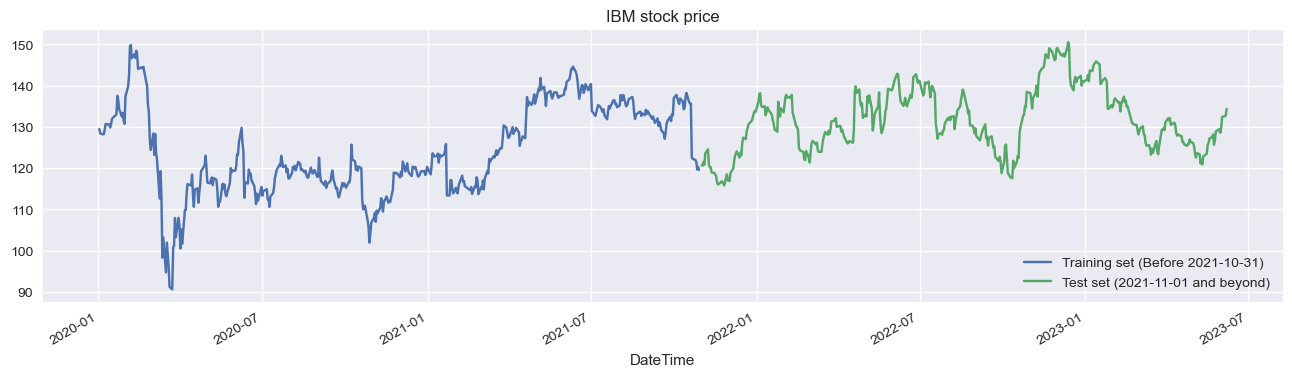

In [20]:
stock[target][train_start_date:train_end_date].plot(figsize=(16,4),legend=True)
stock[target][test_start_date:].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set (Before {train_end_date})',f'Test set ({test_start_date} and beyond)'])
plt.title(f'{symbol_to_fetch} stock price')
plt.show()

In [21]:
# Scaling the training set - I've tried it without scaling and results are very poor.
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [22]:

timesteps = 8
# First, we create data sets where each sample has with 8 timesteps and 1 output
# So for each element of training set, we have 8 previous training set elements
x_train = []
y_train = []

# subtract 1 because y_train will need one more value
for i in range(timesteps, training_set.shape[0] - 1):
    x_train.append(training_set_scaled[i-timesteps:i, 0])
    # start from i-timesteps+1 to shift one step
    y_train.append(training_set_scaled[i-timesteps+1:i+1, 0])

# Notice how the first y_train value becomes the last X_train value for the next sample
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

[0.65575105 0.63832894 0.63445734 0.63590896 0.65397655 0.67704477
 0.67623811 0.67478622] [0.63832894 0.63445734 0.63590896 0.65397655 0.67704477 0.67623811
 0.67478622 0.66220356]
[0.63832894 0.63445734 0.63590896 0.65397655 0.67704477 0.67623811
 0.67478622 0.66220356] [0.63445734 0.63590896 0.65397655 0.67704477 0.67623811 0.67478622
 0.66220356 0.67510909]


### The choice of the number of timesteps is the first thing worth noting. This is also true with RNNs, but with transformers - the optimum choice is often much lower. Three stocks are shown below. With RNNs the number ranges much higher. For ConvLSTMs the optimum is usually between 40-90 timesteps, with transformers it is usually under 10.
![Rmse_by_timestep.png](attachment:ad1bbf60-ca20-47f2-8870-24c056ff7f44.png)

In [23]:
print(x_train.shape, y_train.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(453, 8) (453, 8)
(453, 8, 1) (453, 8)


In [24]:
x_train[0], y_train[0]

(array([[0.65575105],
        [0.63832894],
        [0.63445734],
        [0.63590896],
        [0.65397655],
        [0.67704477],
        [0.67623811],
        [0.67478622]]),
 array([0.63832894, 0.63445734, 0.63590896, 0.65397655, 0.67704477,
        0.67623811, 0.67478622, 0.66220356]))

In [25]:
print(x_train.shape, y_train.shape, type(x_train), type(y_train))
# Interestingly - randomly arranging the samples works well, since we are using validation_split = 0.2, (rather then validation_data = )
# It is worth looking into whether using a K-fold would work better - if so would not use random permutation.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

(453, 8, 1) (453, 8) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Build the model

### Our model processes a tensor of shape [batch size, sequence length, features], where sequence length is the number of time steps in your sample and features is the number of elements you are trying to predict. If we are only trying to predict one thing, such as closing price - then features is 1. When it comes to describing tensor shapes, I am going to refer to batch size as "#samples" so as not to confuse it with batch_size when fitting the model. 

### Fortunately, with recurrent neural nets (such as LSTMs) for timeseries analysis, the inputs [#samples, timesteps, features] are compatible with transformers!
#### The image below is for a single transformer encoder block. For our purposes, the embedding is removed and limited to only to a LayerNormalization layer (which does work better than a BatchNormalization layer). The positional embedding is an option, but frankly - I have tried three diferent time2vec implementations and although the code works, the results are worse (If you can implement a time2vec function which actually improves the rmse score then please share with me). The multi-head attention is already coded for in keras. The feed forward part can be almost anything. We will use a Conv1D layer(because results are good) but you could get away with almost anything, dense layers, another LSTM, whatever you want. You could also stick an LSTM in the embedding layer - it works, if your return_sequences = True, it just give worse results. 

# Build the model

### Our model processes a tensor of shape [batch size, sequence length, features], where sequence length is the number of time steps in your sample and features is the number of elements you are trying to predict. If we are only trying to predict one thing, such as closing price - then features is 1. When it comes to describing tensor shapes, I am going to refer to batch size as "#samples" so as not to confuse it with batch_size when fitting the model. 

### Fortunately, with recurrent neural nets (such as LSTMs) for timeseries analysis, the inputs [#samples, timesteps, features] are compatible with transformers!
#### The image below is for a single transformer encoder block. For our purposes, the embedding is removed and limited to only to a LayerNormalization layer (which does work better than a BatchNormalization layer). The positional embedding is an option, but frankly - I have tried three diferent time2vec implementations and although the code works, the results are worse (If you can implement a time2vec function which actually improves the rmse score then please share with me). The multi-head attention is already coded for in keras. The feed forward part can be almost anything. We will use a Conv1D layer(because results are good) but you could get away with almost anything, dense layers, another LSTM, whatever you want. You could also stick an LSTM in the embedding layer - it works, if your return_sequences = True, it just give worse results. 

<center>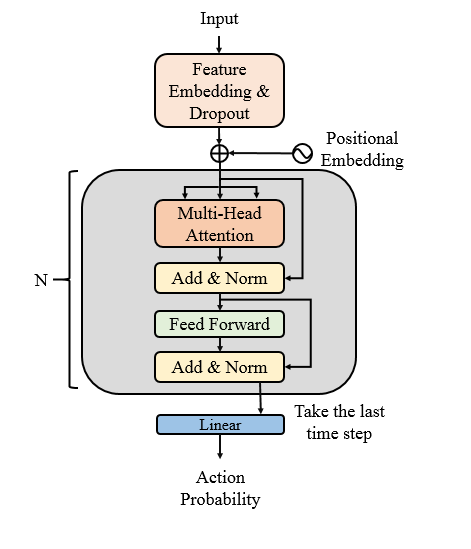</center>

### The main part of our model is now complete. 
### We can stack multiple of those transformer_encoder blocks and we can also proceed to add the final Multi-Layer Perceptron/ DNN head. 

### Apart from a stack of Dense layers, we need to reduce the output tensor of the TransformerEncoder part of our model down to a vector of features for each data point in the current batch. A pooling layer like GlobalAveragePooling1D layer will do this.
GlobalAveragePooling1D input shape is [#samples, timesteps, features] (if channels_first format is chosen), its default output is [#samples, timesteps].

In [26]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    print(f'Input shape: {x.shape}')  # Print input shape

    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        print(f'Transformer block output shape: {x.shape}')  # Print transformer block output shape

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    print(f'Pooled output shape: {x.shape}')  # Print pooled output shape

    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        print(f'After Dense layer shape: {x.shape}')  # Print shape after Dense layer
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)  # this is a pass-through
    print(f'Final output shape: {outputs.shape}')  # Print final output shape
    return keras.Model(inputs, outputs)

In [27]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# This learning rate scheduler is also from Mr. Theodoros Ntakouris' articla at https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3
# I am definetely a fan.

In [28]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

NameError: name 'keras' is not defined

In [29]:
model = build_model(
    input_shape,
    head_size=46,  # Embedding size for attention
    num_heads=60,  # Number of attention heads
    ff_dim=55,  # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=2,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
#model.summary()

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=20,
    callbacks=callbacks,
)


NameError: name 'input_shape' is not defined

# Evaluate model

13/13 [==============================] - 0s 12ms/step
[132.41999817] [132.63999939] [132.69000244]
[129.82000732] [132.41999817] [132.63999939]
[132.55823]


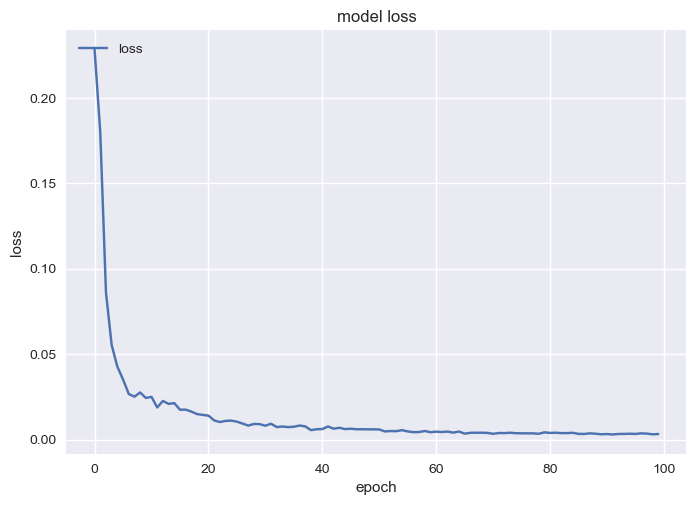

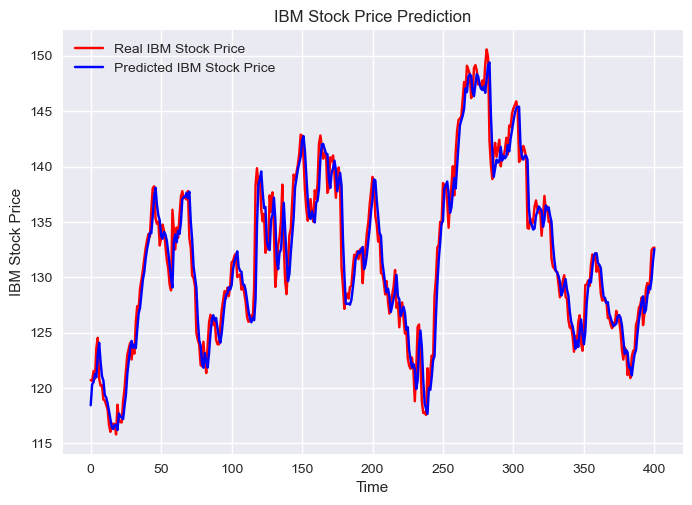

The root mean squared error is 1.99835346759328.


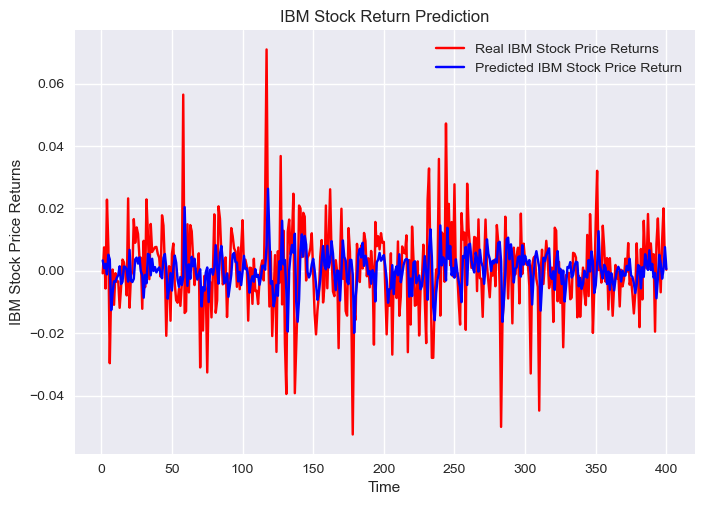

The root mean squared error is 0.014569558308730123.


0.014569558308730123

In [28]:
# First we have to frontload the test data before the inital values of our test_set

dataset_total = pd.concat((original_stock[target][:train_end_date],original_stock[target][test_start_date:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)

X_test = []
for i in range(timesteps,test_set.shape[0] + timesteps):
    X_test.append(inputs[i-timesteps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


print(test_set[-3],test_set[-2], test_set[-1])
shifted_test_set = shift(test_set, 1) #The shift function is defined early in the notebook
print(shifted_test_set[-3],shifted_test_set[-2], shifted_test_set[-1])

print(predicted_stock_price[-1])
prediction_error = test_set - predicted_stock_price # This is the error on the same day
#Before we can calculate the predicted return we have to shift the test_set to the day before so we use the shifted_test_set
predicted_return = (shifted_test_set - predicted_stock_price) / shifted_test_set

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

plot_predictions(test_set,predicted_stock_price,original_symbol)
return_rmse(test_set,predicted_stock_price)

plot_return_predictions(test_set_return,predicted_return,original_symbol)
return_rmse(test_set_return[1:], predicted_return[1:])


# Points of Consideration

### 1. The number of timesteps is a critical factor and the optimal number will vary for each stock. But as a whole the optimal number is lower than for RNNs.
### 2. Unlike RNN's adding Time2Vec embedding does not improve results. 
### 3. elu is the best activation for the final DNN/MLP "classification head".
### 4. Also - I know that what really counts is predicting returns. However if I use stock['return'] instead of stock['Close'] I get vanishing gradients. If anyone can help me solve THAT problem I would greatly appreciate it. 
### 5. In the Price and Return graphs above - there is always a lag, that is expected - but unfortunately it is also very unprofitable. If one ever hopes to apply this - one has to be able to minimize losses, by predicting price reversals. I have tried to apply the same model to predict whether there is a reversal and it works ! but only 50.000 % of the time.

# Can we use technical indicators to predict reversal?
### Fortunataley our database has them precalculated.
